# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
# %pip install belashovplot
# %pip install optuna
# %pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm
import pickle

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 300
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 7

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 16.722 мкм


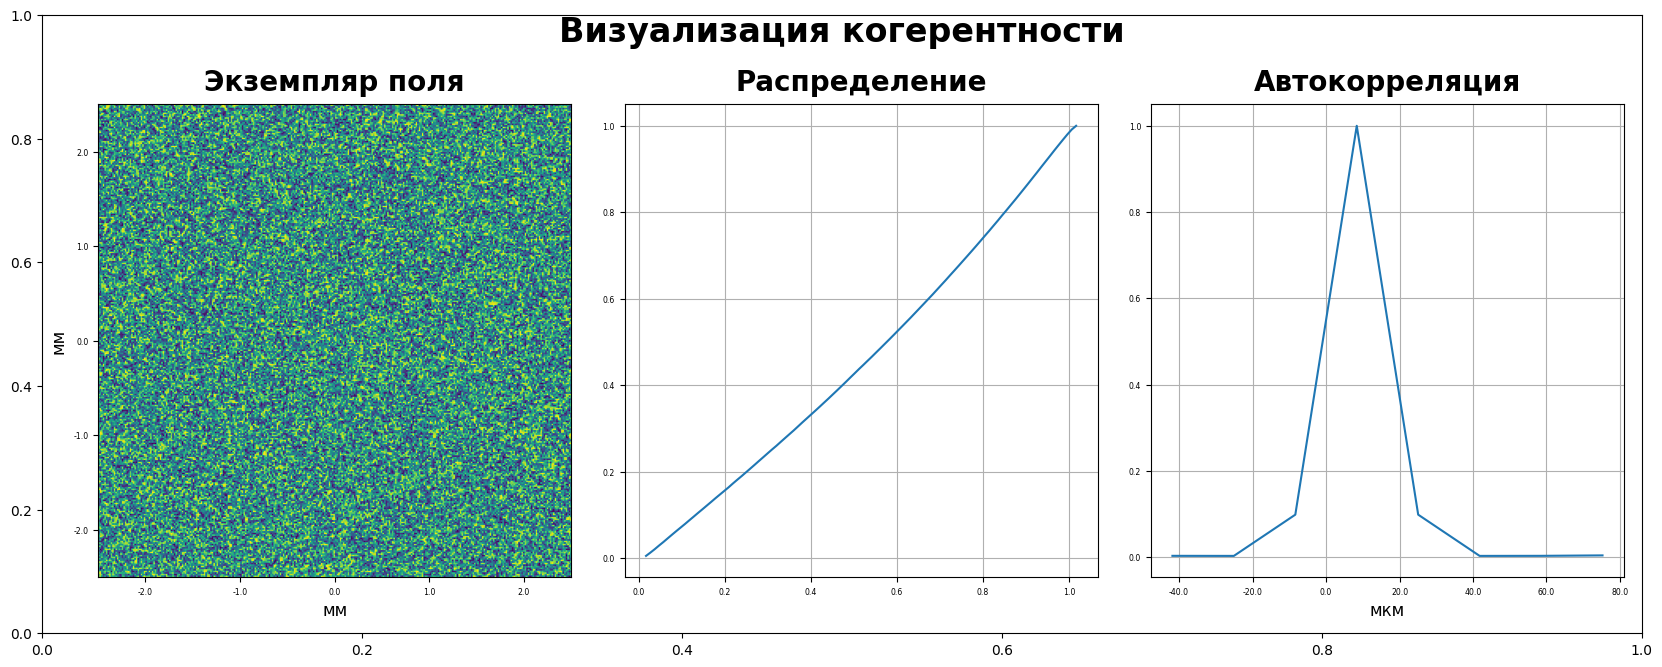

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

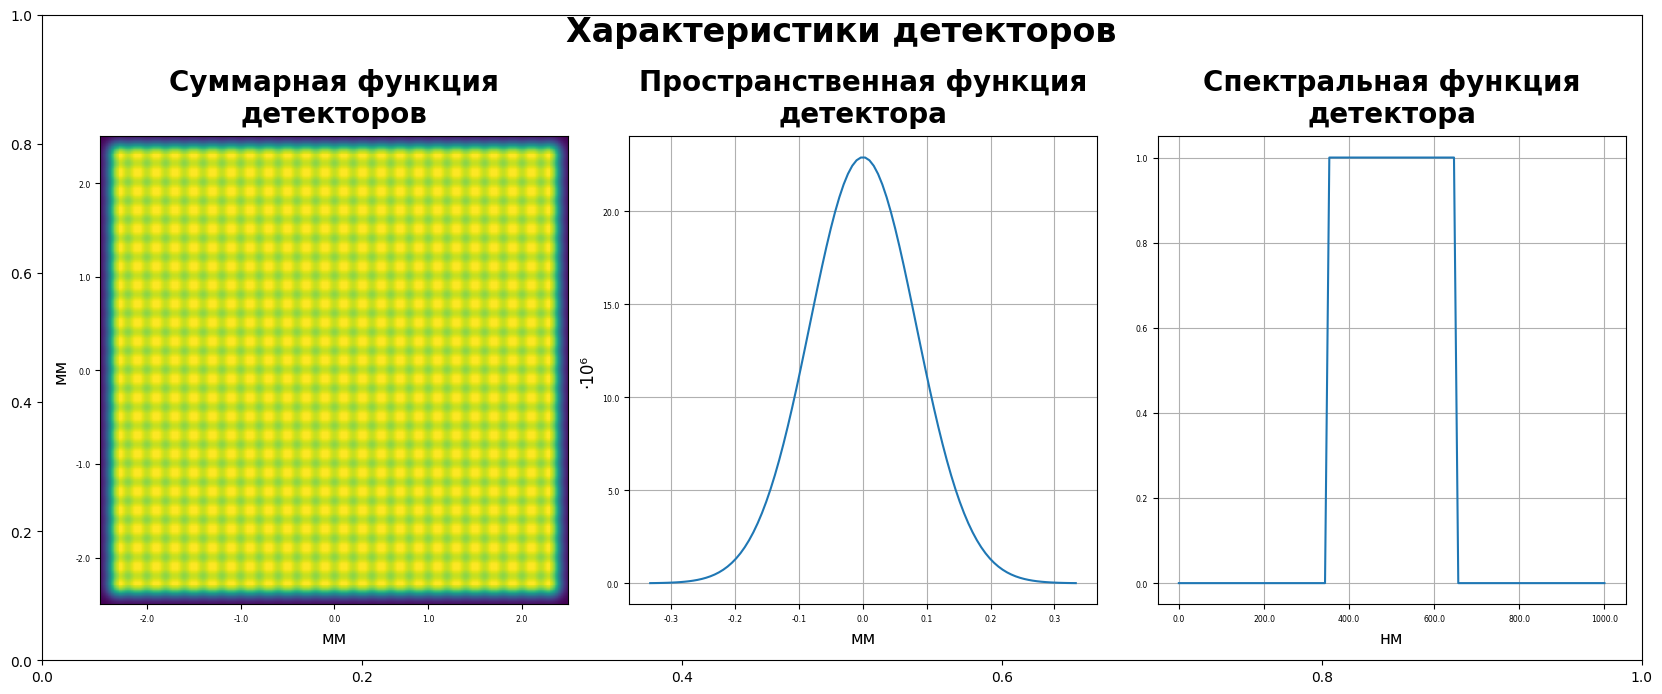

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [14]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция 

In [15]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [16]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [17]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device) 
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


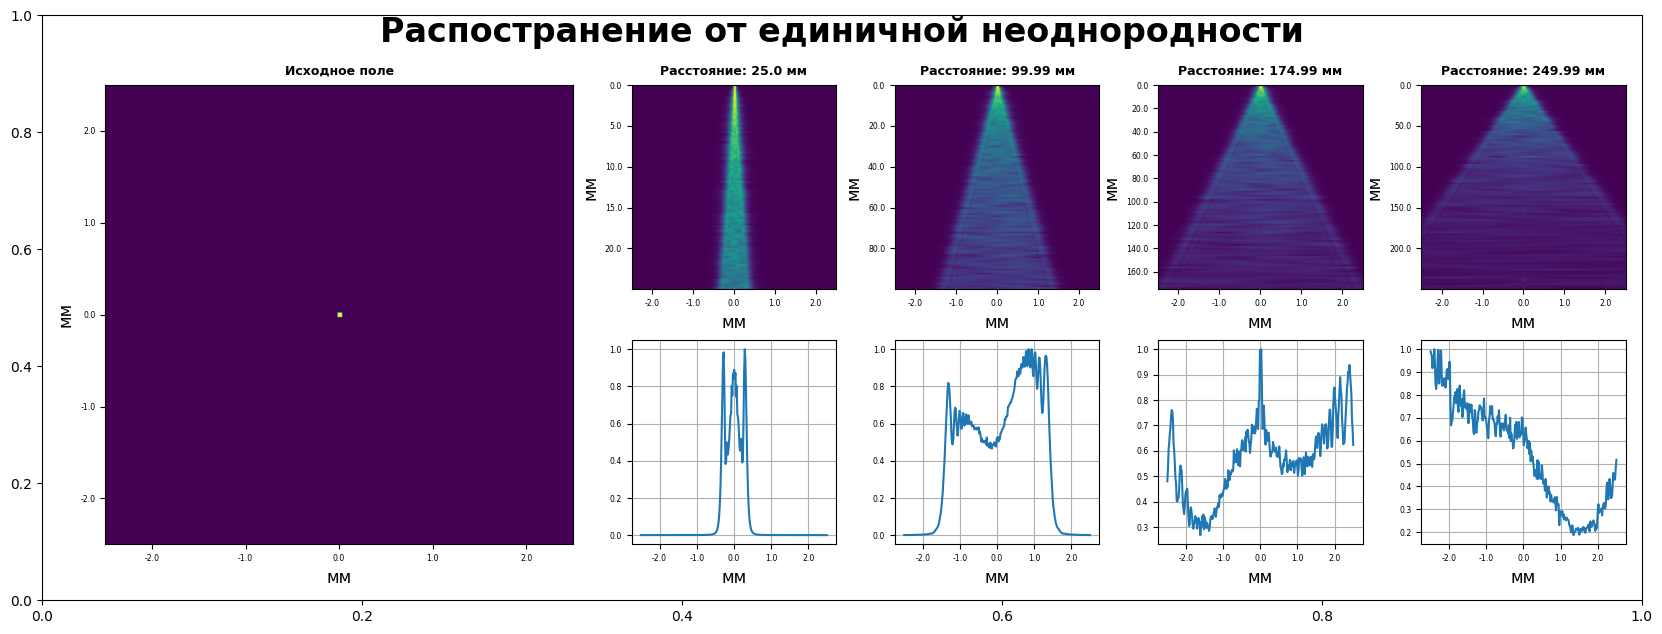

In [18]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [19]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (80.0E-3, 180.0E-3)

In [20]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 40)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [21]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       300
Количество пикселей маски:                100
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     50.0 мкм
Расстояние между слоями:                  249.987 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           50.0 мкм
Количество усреднений:                    7


## Функция цели для optuna и оптимизация

In [22]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")

    #Инициализация электронной 
    electronic = timm.create_model('resnet18', pretrained=False,  in_chans=1, num_classes=10).to(device)
    
    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker(sub_chunks=mean_samples)
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)
    
    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(study_name="ID2NN Fixed", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-06 03:37:45,425] Using an existing study with name 'ID2NN Fixed' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=100)

Эксперимент:
	Количетсво масок:  5
	Размер батча:      28
	Дистанция:         155.256 мм
	Скорость обучения: 0.00048459317790855915
	Пропорция CELoss:  0.06790781283219507
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.2325891656472028, RPI1000: -0.00688323935004885: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1786/1786 [09:28<00:00,  3.14it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:54<00:00,  6.60it/s]
[I 2024-05-06 03:48:09,938] Trial 74 finished with value: 16.82 and parameters: {'masks amount': 5, 'batch size': 28, 'distance': 0.15525618836176477, 'learning rate': 0.00048459317790855915, 'cross entorpy proportion': 0.06790781283219507, 'optimizer type': 'Adam'}. Best is trial 13 with value: 24.23.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         122.177 мм
	Скорость обучения: 0.002975058278086968
	Пропорция CELoss:  0.46315413497220115
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.0282530980269118, RPI1000: -0.04889408078299748: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:25<00:00,  5.35it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:46<00:00, 10.27it/s]
[I 2024-05-06 03:56:23,385] Trial 75 finished with value: 22.33 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.12217667291274498, 'learning rate': 0.002975058278086968, 'cross entorpy proportion': 0.46315413497220115, 'optimizer type': 'Adam'}. Best is trial 13 with value: 24.23.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         122.336 мм
	Скорость обучения: 0.003023487441649603
	Пропорция CELoss:  0.47526216944549765
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.0542904644080937, RPI1000: -0.04875785919504477: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:24<00:00,  5.36it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:46<00:00, 10.23it/s]
[I 2024-05-06 04:04:36,274] Trial 76 finished with value: 19.05 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.12233644701061601, 'learning rate': 0.003023487441649603, 'cross entorpy proportion': 0.47526216944549765, 'optimizer type': 'Adam'}. Best is trial 13 with value: 24.23.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         126.798 мм
	Скорость обучения: 0.012525956367978658
	Пропорция CELoss:  0.5211766680670469
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1744909851884744, RPI1000: -0.04597908951168447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:43<00:00,  4.55it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:52<00:00,  9.04it/s]
[I 2024-05-06 04:14:13,845] Trial 77 finished with value: 17.92 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.12679837796294197, 'learning rate': 0.012525956367978658, 'cross entorpy proportion': 0.5211766680670469, 'optimizer type': 'Adam'}. Best is trial 13 with value: 24.23.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         111.767 мм
	Скорость обучения: 0.006597828283761462
	Пропорция CELoss:  0.04614042913318032
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.17731496018096893, RPI1000: -0.008122747797591721: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:13<00:00,  5.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.98it/s]
[I 2024-05-06 04:22:15,131] Trial 78 finished with value: 25.73 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.11176720495538595, 'learning rate': 0.006597828283761462, 'cross entorpy proportion': 0.04614042913318032, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         112.99 мм
	Скорость обучения: 0.007628855541182704
	Пропорция CELoss:  0.0031594077466717274
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.09367820037283801, RPI1000: -0.002898373656757653: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:14<00:00,  5.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.99it/s]
[I 2024-05-06 04:30:16,626] Trial 79 finished with value: 21.26 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.11298961658316249, 'learning rate': 0.007628855541182704, 'cross entorpy proportion': 0.0031594077466717274, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         121.387 мм
	Скорость обучения: 0.021125824169145973
	Пропорция CELoss:  0.05517355278617542
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.19804290481362127, RPI1000: -0.006987437227928989: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:12<00:00,  5.51it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:45<00:00, 10.49it/s]
[I 2024-05-06 04:38:16,276] Trial 80 finished with value: 20.07 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.12138656560515518, 'learning rate': 0.021125824169145973, 'cross entorpy proportion': 0.05517355278617542, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         125.182 мм
	Скорость обучения: 0.008028636661863472
	Пропорция CELoss:  0.45950147813000275
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.019985631312068, RPI1000: -0.04483411953104666: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:14<00:00,  5.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.96it/s]
[I 2024-05-06 04:46:18,149] Trial 81 finished with value: 23.46 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.12518241464184954, 'learning rate': 0.008028636661863472, 'cross entorpy proportion': 0.45950147813000275, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         111.748 мм
	Скорость обучения: 0.00807818654194712
	Пропорция CELoss:  0.047179400938547514
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.17894511259958723, RPI1000: -0.006235179443177251: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:14<00:00,  5.76it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.97it/s]
[I 2024-05-06 04:54:19,496] Trial 82 finished with value: 23.1 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.11174752182916843, 'learning rate': 0.00807818654194712, 'cross entorpy proportion': 0.047179400938547514, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      20
	Дистанция:         109.655 мм
	Скорость обучения: 0.007780700022321093
	Пропорция CELoss:  0.05475918816967729
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.19793247611552203, RPI1000: -0.0071227659289333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:36<00:00,  4.84it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.37it/s]
[I 2024-05-06 05:03:51,568] Trial 83 finished with value: 20.49 and parameters: {'masks amount': 5, 'batch size': 20, 'distance': 0.10965492402071772, 'learning rate': 0.007780700022321093, 'cross entorpy proportion': 0.05475918816967729, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         125.466 мм
	Скорость обучения: 0.01610985331762623
	Пропорция CELoss:  0.03999494600137034
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.17000852636829192, RPI1000: -0.00578046542917093: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:13<00:00,  5.50it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:45<00:00, 10.44it/s]
[I 2024-05-06 05:11:52,236] Trial 84 finished with value: 21.68 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.1254658889608697, 'learning rate': 0.01610985331762623, 'cross entorpy proportion': 0.03999494600137034, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         110.767 мм
	Скорость обучения: 0.011851081813557799
	Пропорция CELoss:  0.13718831636147177
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.37501683467667823, RPI1000: -0.013200861364770491: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:14<00:00,  5.75it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.93it/s]
[I 2024-05-06 05:19:54,488] Trial 85 finished with value: 21.48 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.1107673776692929, 'learning rate': 0.011851081813557799, 'cross entorpy proportion': 0.13718831636147177, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      23
	Дистанция:         114.412 мм
	Скорость обучения: 0.004893657117938282
	Пропорция CELoss:  0.5790533233802212
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.2839101578153982, RPI1000: -0.06473358949823578: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [08:41<00:00,  4.17it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:52<00:00,  8.24it/s]
[I 2024-05-06 05:29:30,768] Trial 86 finished with value: 20.98 and parameters: {'masks amount': 5, 'batch size': 23, 'distance': 0.1144120644452242, 'learning rate': 0.004893657117938282, 'cross entorpy proportion': 0.5790533233802212, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      20
	Дистанция:         124.246 мм
	Скорость обучения: 0.007615620878606917
	Пропорция CELoss:  0.11288545507892869
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.31299122301657123, RPI1000: -0.012689739157794104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:37<00:00,  4.83it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.41it/s]
[I 2024-05-06 05:39:03,412] Trial 87 finished with value: 23.32 and parameters: {'masks amount': 5, 'batch size': 20, 'distance': 0.12424621623072137, 'learning rate': 0.007615620878606917, 'cross entorpy proportion': 0.11288545507892869, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         120.077 мм
	Скорость обучения: 0.008379623870621251
	Пропорция CELoss:  0.22201821806810929
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5407718771897396, RPI1000: -0.02242153293961977: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:36<00:00,  4.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:53<00:00,  8.98it/s]
[I 2024-05-06 05:48:34,954] Trial 88 finished with value: 21.44 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.12007661810628269, 'learning rate': 0.008379623870621251, 'cross entorpy proportion': 0.22201821806810929, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      20
	Дистанция:         124.86 мм
	Скорость обучения: 0.0031623761048084685
	Пропорция CELoss:  0.10910947552634952
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3113840040183106, RPI1000: -0.012110328278174308: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [10:11<00:00,  4.09it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.26it/s]
[I 2024-05-06 05:59:49,250] Trial 89 finished with value: 21.23 and parameters: {'masks amount': 6, 'batch size': 20, 'distance': 0.12485967459437294, 'learning rate': 0.0031623761048084685, 'cross entorpy proportion': 0.10910947552634952, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      22
	Дистанция:         115.624 мм
	Скорость обучения: 0.015592560340434462
	Пропорция CELoss:  0.16885312677082043
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.45323386379580616, RPI1000: -0.008528031043504395: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [10:25<00:00,  3.63it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [01:00<00:00,  7.55it/s]
[I 2024-05-06 06:11:16,634] Trial 90 finished with value: 14.65 and parameters: {'masks amount': 6, 'batch size': 22, 'distance': 0.11562391646024386, 'learning rate': 0.015592560340434462, 'cross entorpy proportion': 0.16885312677082043, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         131.195 мм
	Скорость обучения: 0.006142014330944425
	Пропорция CELoss:  0.055026317237982396
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.1957439209441647, RPI1000: -0.007516982605792701: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:36<00:00,  4.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:53<00:00,  8.96it/s]
[I 2024-05-06 06:20:47,760] Trial 91 finished with value: 19.94 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.13119486805303493, 'learning rate': 0.006142014330944425, 'cross entorpy proportion': 0.055026317237982396, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         111.438 мм
	Скорость обучения: 0.011203977175215924
	Пропорция CELoss:  0.08378640817368413
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.25600408861490265, RPI1000: -0.009850497743492087: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:15<00:00,  5.74it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.94it/s]
[I 2024-05-06 06:28:50,682] Trial 92 finished with value: 21.23 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.1114381457153445, 'learning rate': 0.011203977175215924, 'cross entorpy proportion': 0.08378640817368413, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         103.037 мм
	Скорость обучения: 0.021794933594491195
	Пропорция CELoss:  0.03615540905498808
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.16532796199699382, RPI1000: -0.003259377286114616: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:36<00:00,  4.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:53<00:00,  8.98it/s]
[I 2024-05-06 06:38:22,163] Trial 93 finished with value: 13.53 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.1030374861780336, 'learning rate': 0.021794933594491195, 'cross entorpy proportion': 0.03615540905498808, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         120.436 мм
	Скорость обучения: 0.00712444814672683
	Пропорция CELoss:  0.20140552865364098
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.4984988732136405, RPI1000: -0.020465832232782897: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:14<00:00,  5.75it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.96it/s]
[I 2024-05-06 06:46:24,528] Trial 94 finished with value: 20.15 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.12043570733605091, 'learning rate': 0.00712444814672683, 'cross entorpy proportion': 0.20140552865364098, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      22
	Дистанция:         127.785 мм
	Скорость обучения: 0.010391306220990692
	Пропорция CELoss:  0.11087341161520016
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3205186957117591, RPI1000: -0.010286977395967808: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [08:45<00:00,  4.33it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:52<00:00,  8.59it/s]
[I 2024-05-06 06:56:04,316] Trial 95 finished with value: 19.27 and parameters: {'masks amount': 5, 'batch size': 22, 'distance': 0.12778486418867557, 'learning rate': 0.010391306220990692, 'cross entorpy proportion': 0.11087341161520016, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         123.796 мм
	Скорость обучения: 0.0034960750017429295
	Пропорция CELoss:  0.0008931040423661649
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.09020493275432821, RPI1000: -0.0026538269517439738: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:14<00:00,  5.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:45<00:00, 10.45it/s]
[I 2024-05-06 07:04:05,792] Trial 96 finished with value: 19.62 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.12379639698231809, 'learning rate': 0.0034960750017429295, 'cross entorpy proportion': 0.0008931040423661649, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      20
	Дистанция:         118.488 мм
	Скорость обучения: 0.005449642464407737
	Пропорция CELoss:  0.16620943524146406
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.41040082133186107, RPI1000: -0.01700471247629964: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:38<00:00,  4.83it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.36it/s]
[I 2024-05-06 07:13:39,049] Trial 97 finished with value: 19.67 and parameters: {'masks amount': 5, 'batch size': 20, 'distance': 0.11848766800738136, 'learning rate': 0.005449642464407737, 'cross entorpy proportion': 0.16620943524146406, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      22
	Дистанция:         130.251 мм
	Скорость обучения: 0.004569966835614537
	Пропорция CELoss:  0.46591828443567135
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.086438273180083, RPI1000: -0.010947677193902399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [07:10<00:00,  5.28it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:45<00:00,  9.99it/s]
[I 2024-05-06 07:21:36,851] Trial 98 finished with value: 14.97 and parameters: {'masks amount': 4, 'batch size': 22, 'distance': 0.1302513164849317, 'learning rate': 0.004569966835614537, 'cross entorpy proportion': 0.46591828443567135, 'optimizer type': 'Adagrad'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      20
	Дистанция:         107.286 мм
	Скорость обучения: 0.013229337938442606
	Пропорция CELoss:  0.3421610841310038
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.7797049412636635, RPI1000: -0.03191134076119038: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:37<00:00,  4.83it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.36it/s]
[I 2024-05-06 07:31:09,719] Trial 99 finished with value: 19.95 and parameters: {'masks amount': 5, 'batch size': 20, 'distance': 0.10728628320460971, 'learning rate': 0.013229337938442606, 'cross entorpy proportion': 0.3421610841310038, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      23
	Дистанция:         116.565 мм
	Скорость обучения: 0.005692913763094013
	Пропорция CELoss:  0.5098624870531283
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.1027262613011741, RPI1000: -0.05938135644085106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2174/2174 [07:10<00:00,  5.05it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:45<00:00,  9.55it/s]
[I 2024-05-06 07:39:07,261] Trial 100 finished with value: 21.82 and parameters: {'masks amount': 4, 'batch size': 23, 'distance': 0.11656485349602003, 'learning rate': 0.005692913763094013, 'cross entorpy proportion': 0.5098624870531283, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      25
	Дистанция:         113.291 мм
	Скорость обучения: 0.0017159170973706152
	Пропорция CELoss:  0.43609131586508976
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.9725265556068746, RPI1000: -0.051511921744247874: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:08<00:00,  4.67it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.86it/s]
[I 2024-05-06 07:47:02,569] Trial 101 finished with value: 21.99 and parameters: {'masks amount': 4, 'batch size': 25, 'distance': 0.11329077699208105, 'learning rate': 0.0017159170973706152, 'cross entorpy proportion': 0.43609131586508976, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      25
	Дистанция:         111.816 мм
	Скорость обучения: 0.008446136857607145
	Пропорция CELoss:  0.5610277262652554
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.204617561593067, RPI1000: -0.06503235119767711: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:07<00:00,  4.67it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:45<00:00,  8.85it/s]
[I 2024-05-06 07:54:57,533] Trial 102 finished with value: 17.96 and parameters: {'masks amount': 4, 'batch size': 25, 'distance': 0.11181560550979994, 'learning rate': 0.008446136857607145, 'cross entorpy proportion': 0.5610277262652554, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         114.342 мм
	Скорость обучения: 0.002454870641019913
	Пропорция CELoss:  0.23536924459881614
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5699767429480774, RPI1000: -0.02421482764392827: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:15<00:00,  5.74it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.96it/s]
[I 2024-05-06 08:03:00,170] Trial 103 finished with value: 22.55 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.11434158790970406, 'learning rate': 0.002454870641019913, 'cross entorpy proportion': 0.23536924459881614, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      20
	Дистанция:         103.821 мм
	Скорость обучения: 0.0015081017862128053
	Пропорция CELoss:  0.040769946482527214
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.17630443046811747, RPI1000: -0.005040738610261505: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [08:37<00:00,  4.83it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.42it/s]
[I 2024-05-06 08:12:33,007] Trial 104 finished with value: 19.55 and parameters: {'masks amount': 5, 'batch size': 20, 'distance': 0.10382122306599, 'learning rate': 0.0015081017862128053, 'cross entorpy proportion': 0.040769946482527214, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         114.574 мм
	Скорость обучения: 0.0022624430897186694
	Пропорция CELoss:  0.1526110288678141
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.39661814023029324, RPI1000: -0.018644014846996057: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:14<00:00,  5.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:45<00:00, 10.43it/s]
[I 2024-05-06 08:20:34,628] Trial 105 finished with value: 21.78 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.11457399582152729, 'learning rate': 0.0022624430897186694, 'cross entorpy proportion': 0.1526110288678141, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      20
	Дистанция:         108.488 мм
	Скорость обучения: 0.0025805645910917338
	Пропорция CELoss:  0.23585885037400073
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.5797622618451233, RPI1000: -0.023325503002082953: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [10:11<00:00,  4.09it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.21it/s]
[I 2024-05-06 08:31:49,099] Trial 106 finished with value: 21.0 and parameters: {'masks amount': 6, 'batch size': 20, 'distance': 0.10848792591866388, 'learning rate': 0.0025805645910917338, 'cross entorpy proportion': 0.23585885037400073, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      21
	Дистанция:         123.412 мм
	Скорость обучения: 0.0017425367336991963
	Пропорция CELoss:  0.12735334874099385
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.3549054278222447, RPI1000: -0.01394438864889237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [07:14<00:00,  5.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:45<00:00, 10.47it/s]
[I 2024-05-06 08:39:50,972] Trial 107 finished with value: 21.57 and parameters: {'masks amount': 4, 'batch size': 21, 'distance': 0.12341181626869892, 'learning rate': 0.0017425367336991963, 'cross entorpy proportion': 0.12735334874099385, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      22
	Дистанция:         113.217 мм
	Скорость обучения: 0.0036724232551341063
	Пропорция CELoss:  0.0708712783386102
	Тип оптимизатора:  SGD
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.24316702361296386, RPI1000: -0.0018234863301494415: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2273/2273 [08:41<00:00,  4.36it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:52<00:00,  8.62it/s]
[I 2024-05-06 08:49:26,577] Trial 108 finished with value: 14.51 and parameters: {'masks amount': 5, 'batch size': 22, 'distance': 0.11321738337150647, 'learning rate': 0.0036724232551341063, 'cross entorpy proportion': 0.0708712783386102, 'optimizer type': 'SGD'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      20
	Дистанция:         117.755 мм
	Скорость обучения: 0.023515327504137998
	Пропорция CELoss:  0.2887420179316077
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.7020326252563989, RPI1000: -0.02784619211624526: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:15<00:00,  5.74it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.93it/s]
[I 2024-05-06 08:57:30,069] Trial 109 finished with value: 21.8 and parameters: {'masks amount': 4, 'batch size': 20, 'distance': 0.1177550877000687, 'learning rate': 0.023515327504137998, 'cross entorpy proportion': 0.2887420179316077, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      21
	Дистанция:         121.567 мм
	Скорость обучения: 0.015620388253434817
	Пропорция CELoss:  0.0952959931560344
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.28094089177123094, RPI1000: -0.009871493682857457: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [08:36<00:00,  4.61it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 477/477 [00:53<00:00,  8.99it/s]
[I 2024-05-06 09:07:01,366] Trial 110 finished with value: 20.06 and parameters: {'masks amount': 5, 'batch size': 21, 'distance': 0.12156654109476478, 'learning rate': 0.015620388253434817, 'cross entorpy proportion': 0.0952959931560344, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      27
	Дистанция:         101.151 мм
	Скорость обучения: 0.006802583821472782
	Пропорция CELoss:  0.3914823142525248
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 0.8773211049119207, RPI1000: -0.058664064284681856: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1852/1852 [07:15<00:00,  4.25it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [00:45<00:00,  8.20it/s]
[I 2024-05-06 09:15:04,164] Trial 111 finished with value: 24.59 and parameters: {'masks amount': 4, 'batch size': 27, 'distance': 0.10115066979157818, 'learning rate': 0.006802583821472782, 'cross entorpy proportion': 0.3914823142525248, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      27
	Дистанция:         97.92 мм
	Скорость обучения: 0.009174212402287062
	Пропорция CELoss:  0.45716796479821725
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.0105127428203868, RPI1000: -0.0567317700959596: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1852/1852 [07:21<00:00,  4.19it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 371/371 [00:51<00:00,  7.21it/s]
[I 2024-05-06 09:23:19,042] Trial 112 finished with value: 21.88 and parameters: {'masks amount': 4, 'batch size': 27, 'distance': 0.09791993667903032, 'learning rate': 0.009174212402287062, 'cross entorpy proportion': 0.45716796479821725, 'optimizer type': 'Adam'}. Best is trial 78 with value: 25.73.


Эксперимент:
	Количетсво масок:  4
	Размер батча:      25
	Дистанция:         110.485 мм
	Скорость обучения: 0.0068771967142893485
	Пропорция CELoss:  0.4933511674476149
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.179011189002431, RPI1000: -1.249896430246319:   7%|████████▎                                                                                                                | 138/2000 [00:33<07:04,  4.38it/s]

In [ ]:
print("Лучшие гиперпараметры:", study.best_trial.params)

In [ ]:
len(study.trials)